In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By


chrome_options = Options()
# chrome_options.add_argument("--headless")  # 창을 보이지 않게 하는 옵션
chrome_options.add_argument("--disable-gpu")  # GPU 가속을 비활성화

In [2]:
sections = {
    'politics' : 'section/100',
    'economy'  : 'section/101',
    'social'   : 'section/102',
    'culture'  : 'section/103',
    'international' : 'section/104',
    'science'  : 'section/105',
}

driver = webdriver.Chrome(options=chrome_options)
news_url = 'https://news.naver.com/'


headline_tites = {}

for section in sections.keys():
    tup = []

    section_url = f'{news_url}{sections[section]}'
    driver.get(section_url)

    div_elements = driver.find_elements(By.CLASS_NAME, 'sa_text')

    for div_element in div_elements:
        a_tag  = div_element.find_element(By.TAG_NAME, 'a')
        a_href = a_tag.get_attribute('href')

        strong_element = div_element.find_element(By.CLASS_NAME, 'sa_text_strong')
        strong_text    = strong_element.text

        if len(tup) < 5:
            tup.append((a_href, strong_text))
        else:
            break

    headline_tites[section] = tup

In [3]:
headline_tites

{'politics': [('https://n.news.naver.com/mnews/article/052/0002094747',
   "오늘 10·16 선거운동 시작...여야, '격전지' 유세장으로"),
  ('https://n.news.naver.com/mnews/article/214/0001377837',
   '조국, 야권 분열 우려에 "목에 칼 들어와도 윤 정권 손 안 잡아"'),
  ('https://n.news.naver.com/mnews/article/011/0004398912',
   '한동훈 "김건희 특검법 통과되면 사법질서 흔들려…부결이 맞다"'),
  ('https://n.news.naver.com/mnews/article/009/0005373441',
   '금투세 갈팡질팡 민주, 4일 의총서 결론'),
  ('https://n.news.naver.com/mnews/article/055/0001194781',
   '"특검법 부결이 맞다" 표 단속…"여당이 호위병인가"')],
 'economy': [('https://n.news.naver.com/mnews/article/018/0005849047',
   '‘플라스틱 저감’ 국내 최초 질소 충전 먹는샘물 8일 출시'),
  ('https://n.news.naver.com/mnews/article/003/0012816478',
   "영풍정밀, '최윤범 반격'에 4% 급등…분쟁 고조(종합)"),
  ('https://n.news.naver.com/mnews/article/001/0014962050',
   "이마트, 오는 10일까지 '슈퍼델리 페스타'…닭강정 등 30% 할인"),
  ('https://n.news.naver.com/mnews/article/011/0004398896',
   '1~9월 농식품 수출액 10조원 육박…‘역대 최대’'),
  ('https://n.news.naver.com/mnews/article/119/0002877602',
   '비트코인, 중동 전쟁 긴장감 

In [4]:
from sentence_transformers import SentenceTransformer

c:\Users\geum\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [5]:
model = SentenceTransformer('snunlp/KR-SBERT-Medium-extended-klueNLItriplet_PARpair_QApair-klueSTS')
model = model.to('cuda')

In [6]:
import numpy as np

sentences = ["안녕 넌 누구니?", "오늘의 날씨는 어때?", "부산대학교에 대해서 알고 있어?"]
sentence_vec = model.encode(sentences, convert_to_numpy=True)
sentence_vec_mean = np.mean(sentence_vec, axis=0)

c:\Users\geum\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [7]:
import pickle

with open('avg_senti_vec.pkl', 'rb') as file:
    senti_dict = pickle.load(file)

best_css   = -float('inf')
best_senti = None

for key, value in senti_dict.items():
    css = model.similarity(sentence_vec_mean, value)

    if css > best_css:
        best_css   = css
        best_senti = key

print(best_senti)

neutral


In [8]:
recommends = {}
recommend_str = None

for topic in headline_tites.keys():
    best_css  = -float('inf')
    best_news = None
    best_title = None

    for link, title in headline_tites[topic]:
        value = model.encode(title)
        css   = model.similarity(sentence_vec_mean, value)

        if css > best_css:
            best_css  = css
            best_news = link
            best_title = title

    recommends[topic] = (best_news, best_title)

recommends

{'politics': ('https://n.news.naver.com/mnews/article/052/0002094747',
  "오늘 10·16 선거운동 시작...여야, '격전지' 유세장으로"),
 'economy': ('https://n.news.naver.com/mnews/article/011/0004398896',
  '1~9월 농식품 수출액 10조원 육박…‘역대 최대’'),
 'social': ('https://n.news.naver.com/mnews/article/031/0000873603',
  '윤일현 국민의힘 후보 “금정이 키운 일 잘할 수 있는 구청장 필요”'),
 'culture': ('https://n.news.naver.com/mnews/article/448/0000480716',
  "내일 개천절, 쌀쌀해요…전국 대부분 '비'[날씨]"),
 'international': ('https://n.news.naver.com/mnews/article/025/0003390558',
  '기상청 "18호 태풍 \'끄라톤\', 한반도 직접 영향 없을 듯"'),
 'science': ('https://n.news.naver.com/mnews/article/014/0005248744',
  "내부통제에도 활용...진옥동 신한금융 회장의 'AI 사랑'")}

In [9]:
import re

articles = {}

for topic in recommends:
    link = recommends[topic][0]

    driver.get(link)

    article = driver.find_element(By.CLASS_NAME, 'go_trans._article_content').text

    article = article.replace('\n', '')
    article = re.sub('[^가-힣]', ' ', article)
    
    articles[topic] = article

In [10]:
import konlpy

kkma = konlpy.tag.Kkma()

In [11]:
article_vec   = {}
article_nouns = {}

for topic in articles:
    text = articles[topic]

    nouns = kkma.nouns(text)

    vec = model.encode(nouns, convert_to_numpy=True)

    article_vec[topic] = vec
    article_nouns[topic] = nouns

article_nouns

{'politics': ['기초',
  '기초단체장',
  '단체장',
  '곳',
  '재',
  '재보궐',
  '보궐',
  '선거',
  '여당',
  '후보',
  '내부',
  '금정',
  '인천',
  '강화',
  '수성',
  '필요',
  '지도부',
  '힘',
  '추',
  '추경호',
  '경',
  '호',
  '오늘',
  '군수',
  '출정식',
  '참여',
  '등',
  '지원',
  '앵커',
  '일',
  '재보궐선거',
  '공식',
  '선거운동',
  '운동',
  '시작',
  '기초자치단체장',
  '자치',
  '명과',
  '서울시',
  '교육감',
  '명',
  '여야',
  '첫날',
  '유세장',
  '총력전',
  '모습',
  '국',
  '국회',
  '회',
  '취재',
  '취재기자',
  '기자',
  '연결',
  '자세',
  '내용',
  '강',
  '강민경',
  '민경',
  '앵커',
  '당',
  '등록',
  '상황',
  '일정',
  '이번',
  '기초단체단체장',
  '단체',
  '지역',
  '부산',
  '금정',
  '금정구',
  '구',
  '강화',
  '강화군',
  '군',
  '전',
  '전남',
  '남',
  '영광',
  '영광군',
  '곡성',
  '곡성군',
  '국민',
  '가운데',
  '영광',
  '제외',
  '입장',
  '금',
  '금정군',
  '정군',
  '을',
  '우세',
  '만큼',
  '추경',
  '추경호',
  '원내',
  '원내대표',
  '대표',
  '적극적',
  '지역구',
  '대구',
  '오후',
  '강화풍물시장',
  '풍물',
  '시장',
  '데',
  '박용철',
  '강화군수',
  '참석',
  '차례',
  '방문',
  '한동',
  '한동훈',
  '훈',
  '다음',
  '주',
  '당세',
  '취약',
  '취약지역인',
  '인',
  '곡성',

In [12]:
article_css_sorted = {}

for topic in article_vec:
    css_list = []

    vecs = article_vec[topic]

    for i, vec in enumerate(vecs):
        css = model.similarity(vec, sentence_vec_mean)
        css_list.append((i, css))
    
    css_list_sorted = sorted(css_list, key=lambda x: x[1], reverse=True)

    article_css_sorted[topic] = css_list_sorted

article_css_sorted

{'politics': [(22, tensor([[0.5160]])),
  (176, tensor([[0.3622]])),
  (67, tensor([[0.2924]])),
  (175, tensor([[0.2876]])),
  (133, tensor([[0.2176]])),
  (146, tensor([[0.1967]])),
  (150, tensor([[0.1896]])),
  (96, tensor([[0.1657]])),
  (74, tensor([[0.1630]])),
  (37, tensor([[0.1615]])),
  (40, tensor([[0.1472]])),
  (147, tensor([[0.1472]])),
  (3, tensor([[0.1411]])),
  (77, tensor([[0.1361]])),
  (83, tensor([[0.1361]])),
  (76, tensor([[0.1358]])),
  (61, tensor([[0.1310]])),
  (170, tensor([[0.1238]])),
  (138, tensor([[0.1193]])),
  (169, tensor([[0.1125]])),
  (45, tensor([[0.1117]])),
  (54, tensor([[0.1111]])),
  (29, tensor([[0.1096]])),
  (127, tensor([[0.1077]])),
  (113, tensor([[0.1066]])),
  (28, tensor([[0.1061]])),
  (58, tensor([[0.1061]])),
  (89, tensor([[0.1030]])),
  (42, tensor([[0.1021]])),
  (118, tensor([[0.1018]])),
  (87, tensor([[0.0993]])),
  (99, tensor([[0.0985]])),
  (62, tensor([[0.0982]])),
  (75, tensor([[0.0906]])),
  (52, tensor([[0.0850]])

In [17]:
article_dic_words = {}

for topic in article_css_sorted:
    css_list_sorted = article_css_sorted[topic]

    dic_word = {}

    for idx, css in css_list_sorted:
        freq = int(float(css) * 100)

        if freq > 0:
            dic_word[article_nouns[topic][idx]] = freq
    
    article_dic_words[topic] = dic_word

article_dic_words

{'politics': {'오늘': 51,
  '당신': 36,
  '부산': 29,
  '지금': 28,
  '모두': 21,
  '조국': 19,
  '모든': 18,
  '대표': 16,
  '전': 16,
  '명과': 16,
  '명': 14,
  '조국혁신당': 14,
  '곳': 14,
  '영광': 13,
  '남': 13,
  '상황': 13,
  '내후년': 12,
  '분류': 11,
  '미니': 11,
  '모습': 11,
  '내용': 11,
  '일': 10,
  '구상': 10,
  '다음': 10,
  '앵커': 10,
  '을': 10,
  '첫날': 10,
  '인': 10,
  '금정군': 9,
  '대구': 9,
  '일정': 9,
  '전남': 9,
  '연결': 8,
  '단체': 8,
  '경': 7,
  '호남': 7,
  '기자': 7,
  '원내': 7,
  '교육감': 7,
  '인식': 7,
  '영광군': 7,
  '금정구': 7,
  '등록': 7,
  '시작': 7,
  '분위기': 7,
  '선': 6,
  '예측': 6,
  '금정구청장': 6,
  '호': 6,
  '강민경': 6,
  '풍물': 6,
  '국민': 6,
  '강': 5,
  '공식': 5,
  '최고': 5,
  '추경': 5,
  '지역': 5,
  '만큼': 5,
  '자세': 5,
  '취재기자': 4,
  '뒤': 4,
  '현장': 4,
  '단체장': 4,
  '교육': 4,
  '훈': 4,
  '운동': 4,
  '금': 4,
  '금정': 4,
  '메일': 3,
  '전초전': 3,
  '카카오': 3,
  '월': 3,
  '국회': 3,
  '회': 3,
  '검색': 3,
  '오후': 3,
  '청장': 3,
  '곡성군': 3,
  '혁신당': 3,
  '차례': 3,
  '뉴스': 2,
  '추': 2,
  '제외': 2,
  '단일화': 2,
  '입장': 2,
  '국': 2,
  '내부': 2,


In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

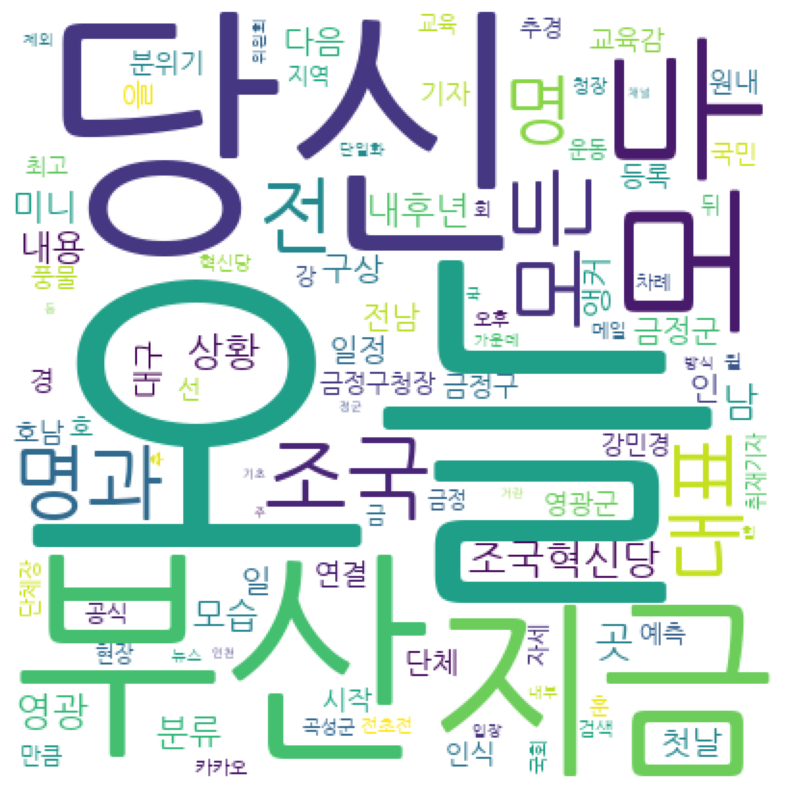

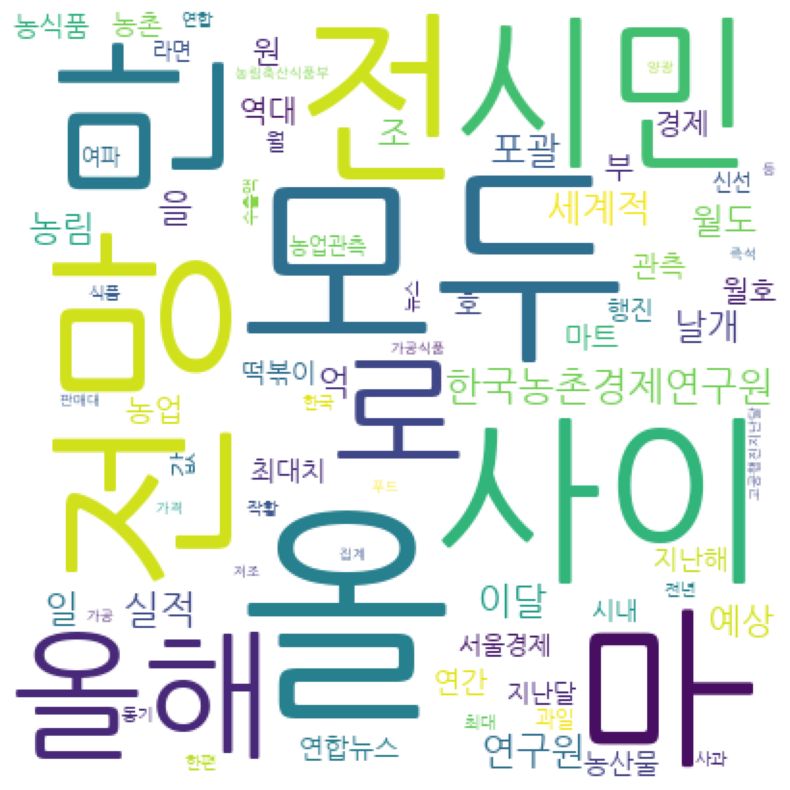

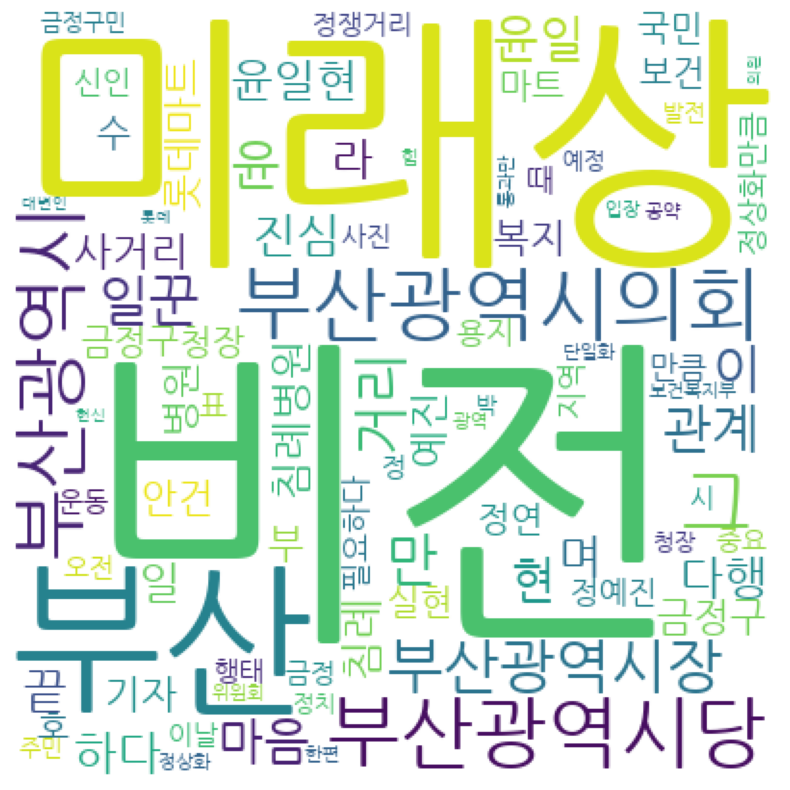

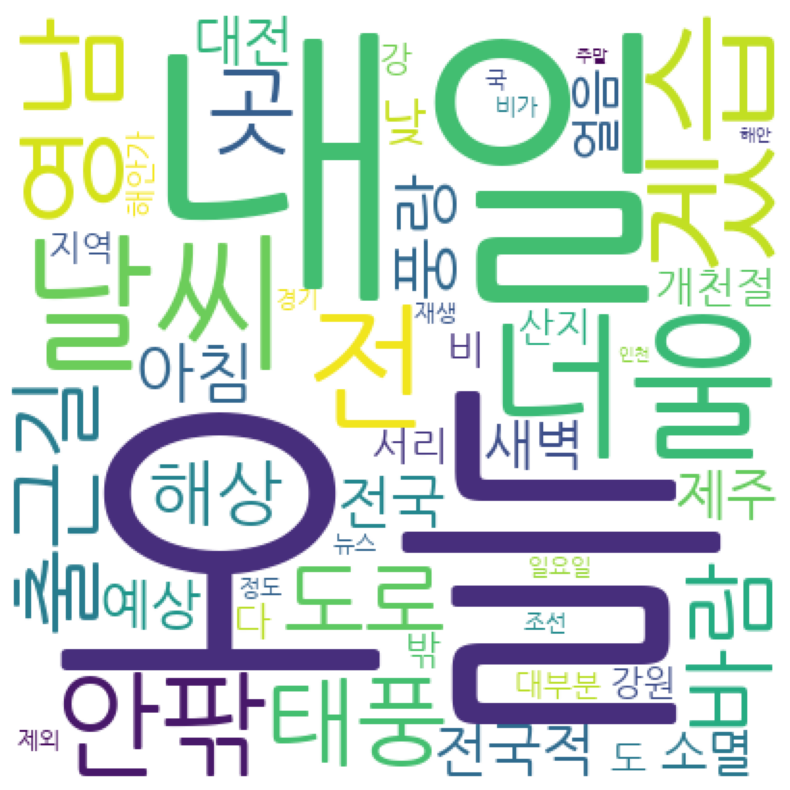

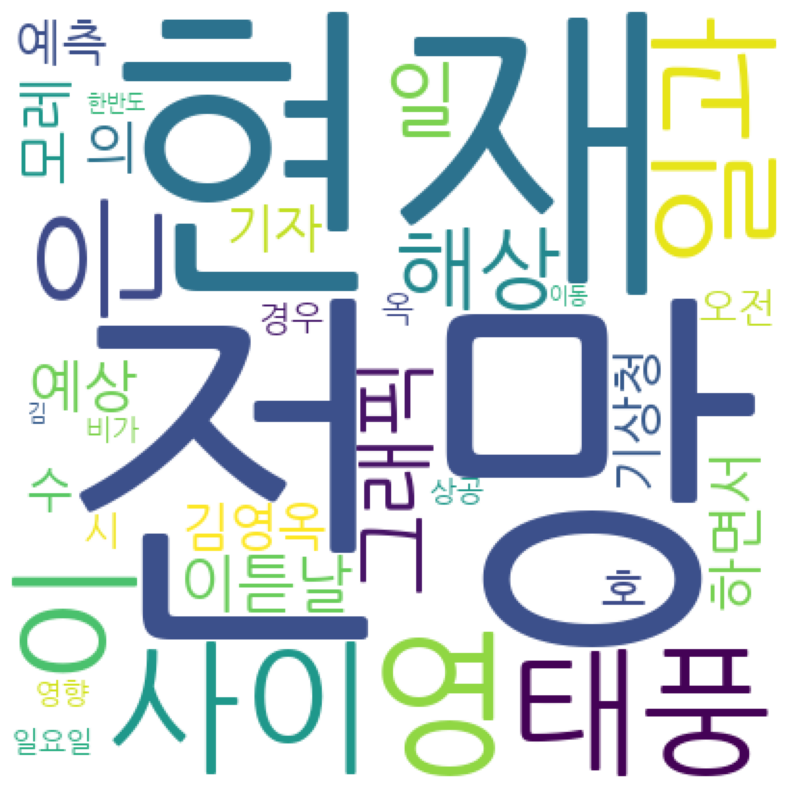

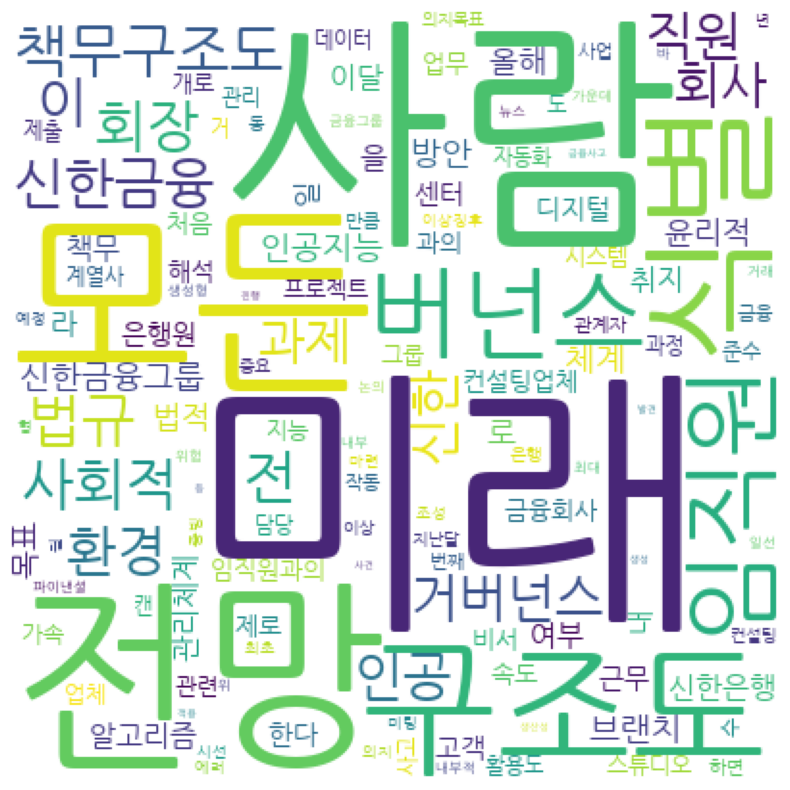

In [20]:
font_path = 'nanum_gothic.TTF'  # 폰트 경로 확인 및 수정
wc = WordCloud(random_state=123, font_path=font_path, width=400, height=400, background_color='white')


imgs = []

for topic in article_dic_words:
    dic_word = article_dic_words[topic]
    img_wordcloud = wc.generate_from_frequencies(dic_word)

    plt.figure(figsize = (10, 10)) # 크기 지정하기
    plt.axis('off') # 축 없애기
    plt.imshow(img_wordcloud) # 결과 보여주기